In [1]:
# !mkdir -p ~/aiffel/face_detector/assets
# !mkdir -p ~/aiffel/face_detector/dataset
# !ln -s ~/data/* ~/aiffel/face_detector

# !cd ~/aiffel/face_detector/widerface && ls wider_face_split  WIDER_test  WIDER_train  WIDER_val

In [2]:
!cd ~/aiffel/face_detector/widerface/wider_face_split && head -20 wider_face_train_bbx_gt.txt

0--Parade/0_Parade_marchingband_1_849.jpg
1
449 330 122 149 0 0 0 0 0 0 
0--Parade/0_Parade_Parade_0_904.jpg
1
361 98 263 339 0 0 0 0 0 0 
0--Parade/0_Parade_marchingband_1_799.jpg
21
78 221 7 8 2 0 0 0 0 0 
78 238 14 17 2 0 0 0 0 0 
113 212 11 15 2 0 0 0 0 0 
134 260 15 15 2 0 0 0 0 0 
163 250 14 17 2 0 0 0 0 0 
201 218 10 12 2 0 0 0 0 0 
182 266 15 17 2 0 0 0 0 0 
245 279 18 15 2 0 0 0 0 0 
304 265 16 17 2 0 0 0 2 1 
328 295 16 20 2 0 0 0 0 0 
389 281 17 19 2 0 0 0 2 0 
406 293 21 21 2 0 1 0 0 0 


이미지 파일 경로

0--Parade/0_Parade_marchingband_0_0.jpg

face bounding box의 갯수
1

face bounding box 좌표 등 상세정보

449 330 122 149 0 0 0 0 0 0 

(각각의 값은 x0, y0, w, h, blur, expression, illumination, invalid, occlusion, pose에 대한 값을 의미합니다.)

In [1]:
import os, cv2, time
import tensorflow as tf
import tqdm
import numpy as np
import math
from itertools import product
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME')+'/aiffel/face_detector'
DATA_PATH = os.path.join(PROJECT_PATH, 'widerface')
MODEL_PATH = os.path.join(PROJECT_PATH, 'checkpoints')
TRAIN_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'train_mask.tfrecord')
VALID_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'val_mask.tfrecord')
CHECKPOINT_PATH = os.path.join(PROJECT_PATH, 'checkpoints')

DATASET_LEN = 12880
BATCH_SIZE = 32
IMAGE_WIDTH = 320
IMAGE_HEIGHT = 256
IMAGE_LABELS = ['background', 'face']

print(tf.__version__)

2.6.0


In [4]:
def parse_box(data):
    x0 = int(data[0])
    y0 = int(data[1])
    w = int(data[2])
    h = int(data[3])
    return x0, y0, w, h

print('슝=3')

슝=3


In [5]:
def parse_widerface(file):
    infos = []
    with open(file) as fp:
        line = fp.readline()
        while line:
            n_object = int(fp.readline())
            boxes = []
            for i in range(n_object):
                box = fp.readline().split(' ')
                x0, y0, w, h = parse_box(box)
                if (w == 0) or (h == 0):
                    continue
                boxes.append([x0, y0, w, h])
            if n_object == 0:
                box = fp.readline().split(' ')
                x0, y0, w, h = parse_box(box)
                boxes.append([x0, y0, w, h])
            infos.append((line.strip(), boxes))
            line = fp.readline()
    return infos

print('슝=3')

슝=3


In [6]:
def process_image(image_file):
    image_string = tf.io.read_file(image_file)
    try:
        image_data = tf.image.decode_jpeg(image_string, channels=3)
        return 0, image_string, image_data
    except tf.errors.InvalidArgumentError:
        return 1, image_string, None

print('슝=3')

슝=3


In [7]:
def xywh_to_voc(file_name, boxes, image_data):
    shape = image_data.shape
    image_info = {}
    image_info['filename'] = file_name
    image_info['width'] = shape[1]
    image_info['height'] = shape[0]
    image_info['depth'] = 3

    difficult = []
    classes = []
    xmin, ymin, xmax, ymax = [], [], [], []

    for box in boxes:
        classes.append(1)
        difficult.append(0)
        xmin.append(box[0])
        ymin.append(box[1])
        xmax.append(box[0] + box[2])
        ymax.append(box[1] + box[3])
    image_info['class'] = classes
    image_info['xmin'] = xmin
    image_info['ymin'] = ymin
    image_info['xmax'] = xmax
    image_info['ymax'] = ymax
    image_info['difficult'] = difficult

    return image_info

print('슝=3')

슝=3


In [8]:
file_path = os.path.join(DATA_PATH, 'wider_face_split', 'wider_face_train_bbx_gt.txt')
for i, info in enumerate(parse_widerface(file_path)):
    print('--------------------')
    image_file = os.path.join(DATA_PATH, 'WIDER_train', 'images', info[0])
    _, image_string, image_data = process_image(image_file)
    boxes = xywh_to_voc(image_file, info[1], image_data)
    print(boxes)
    if i > 3:
        break

--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg', 'width': 1024, 'height': 1385, 'depth': 3, 'class': [1], 'xmin': [449], 'ymin': [330], 'xmax': [571], 'ymax': [479], 'difficult': [0]}
--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_Parade_0_904.jpg', 'width': 1024, 'height': 1432, 'depth': 3, 'class': [1], 'xmin': [361], 'ymin': [98], 'xmax': [624], 'ymax': [437], 'difficult': [0]}
--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_799.jpg', 'width': 1024, 'height': 768, 'depth': 3, 'class': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'xmin': [78, 78, 113, 134, 163, 201, 182, 245, 304, 328, 389, 406, 436, 522, 643, 653, 793, 535, 29, 3, 20], 'ymin': [221, 238, 212, 260, 250, 218, 266, 279, 265, 295, 281, 293, 290, 328, 320, 224, 337, 311, 22

#### TFRecord 만들기
___
오늘 다루게 될 대용량 데이터셋의 처리속도 향상을 위해서, 전처리 작업을 통해 TFRecord 데이터셋으로 변환할 필요가 있습니다. TFRecord란 TensorFlow만의 학습 데이터 저장 포맷으로, 이진(binary) 레코드의 시퀀스를 저장합니다. TFRecord 형태의 학습 데이터를 사용하여 모델 학습을 하면 학습 속도가 개선된다는 장점이 있습니다.

TFRecord는 여러 개의 `tf.train.Example`로 이루어져 있고, 한 개의 `tf.train.Example`은 여러 개의 `tf.train.Feature`로 이루어져 있습니다.

데이터의 단위를 이루는 `tf.train.Example`인스턴스를 생성하는 메소드는 아래와 같습니다.

In [9]:
def make_example(image_string, image_infos):
    for info in image_infos:
        filename = info['filename']
        width = info['width']
        height = info['height']
        depth = info['depth']
        classes = info['class']
        xmin = info['xmin']
        ymin = info['ymin']
        xmax = info['xmax']
        ymax = info['ymax']

    if isinstance(image_string, type(tf.constant(0))):
        encoded_image = [image_string.numpy()]
    else:
        encoded_image = [image_string]

    base_name = [tf.compat.as_bytes(os.path.basename(filename))]
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'filename':tf.train.Feature(bytes_list=tf.train.BytesList(value=base_name)),
        'height':tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'width':tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'classes':tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'x_mins':tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'y_mins':tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'x_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'y_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image_raw':tf.train.Feature(bytes_list=tf.train.BytesList(value=encoded_image))
    }))
    
    return example

print('슝=3')

슝=3


In [10]:
for split in ['train', 'val']:
    if split == 'train':
        output_file = TRAIN_TFRECORD_PATH 
        anno_txt = 'wider_face_train_bbx_gt.txt'
        file_path = 'WIDER_train'
    else:
        output_file = VALID_TFRECORD_PATH
        anno_txt = 'wider_face_val_bbx_gt.txt'
        file_path = 'WIDER_val'

    with tf.io.TFRecordWriter(output_file) as writer:
        for info in tqdm.tqdm(parse_widerface(os.path.join(DATA_PATH, 'wider_face_split', anno_txt))):
            image_file = os.path.join(DATA_PATH, file_path, 'images', info[0])
            error, image_string, image_data = process_image(image_file)
            boxes = xywh_to_voc(image_file, info[1], image_data)

            if not error:
                tf_example = make_example(image_string, [boxes])
                writer.write(tf_example.SerializeToString())

100%|██████████| 3226/3226 [00:16<00:00, 190.05it/s]


In [11]:
!ls ~/aiffel/face_detector/dataset

train_mask.tfrecord  val_mask.tfrecord


### SSD의 Default box
---
SSD 모델의 가장 중요한 특징 중 하나는 Default box를 필요로 한다는 점입니다. 앞서 이야기한 대로 Default box란, object가 존재할 만한 다양한 크기의 box의 좌표 및 클래스 정보를 일정 개수만큼 미리 고정해 둔 것입니다. 흔히 anchor box, prior box라고 부르지요. SSD의 Default box가 약간 다른 점은 여러 층의 feature map에서 box를 만들어 낸다는 점이에요. 층 수 만큼 box 수도 많아지고, 층마다 box의 크기도 다양하게 되죠. ground truth에 해당하는 bounding box와의 IoU를 계산하여 일정 크기(0.5) 이상 겹치는 default box를 선택하는 방식이 RCNN 계열의 sliding window 방식보다 훨씬 속도가 빠르면서도 그와 유사한 정도의 정확도를 얻을 수 있습니다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/gc-9v3-p-4-1_adjeL1p.max-800x600.jpg)
<center>[Default box]</center>
<center>https://manalelaidouni.github.io/Single%20shot%20object%20detection.html</center>

**Q. SSD에서 default box를 선택하는 과정에 대해 설명해봅시다.**
> A.SSD는 여러 층의 feature map에서 bbox를 만들어내기 때문에 층의 수 만큼 box의 수도 많아지고, 층마다 box의 크기도 다양하므로
여러 박스 중에서 ground truth에 해당하는 bounding box와의 IoU를 계산하여 일정 크기(0.5) 이상 겹치는 default box를 선택하게 됩니다.

In [39]:
BOX_MIN_SIZES = [[10, 16, 24], [32, 48], [64, 96], [128, 192, 256]]
BOX_STEPS = [8, 16, 32, 64]

print('슝=3')

슝=3


In [40]:
image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
min_sizes = BOX_MIN_SIZES
steps= BOX_STEPS

feature_maps = [
    [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
    for step in steps
]
feature_maps

[[32, 40], [16, 20], [8, 10], [4, 5]]

In [41]:
boxes = []
for k, f in enumerate(feature_maps):
    for i, j in product(range(f[0]), range(f[1])):
        for min_size in min_sizes[k]:
            s_kx = min_size / image_sizes[1]
            s_ky = min_size / image_sizes[0]
            cx = (j + 0.5) * steps[k] / image_sizes[1]
            cy = (i + 0.5) * steps[k] / image_sizes[0]
            boxes += [cx, cy, s_kx, s_ky]

len(boxes)

18800

In [42]:
pretty_boxes = np.asarray(boxes).reshape([-1, 4])
print(pretty_boxes.shape)
print(pretty_boxes)

(4700, 4)
[[0.0125    0.015625  0.03125   0.0390625]
 [0.0125    0.015625  0.05      0.0625   ]
 [0.0125    0.015625  0.075     0.09375  ]
 ...
 [0.9       0.875     0.4       0.5      ]
 [0.9       0.875     0.6       0.75     ]
 [0.9       0.875     0.8       1.       ]]


In [43]:
def default_box():
    image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
    min_sizes = BOX_MIN_SIZES
    steps= BOX_STEPS
    feature_maps = [
        [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
        for step in steps
    ]
    boxes = []
    for k, f in enumerate(feature_maps):
        for i, j in product(range(f[0]), range(f[1])):
            for min_size in min_sizes[k]:
                s_kx = min_size / image_sizes[1]
                s_ky = min_size / image_sizes[0]
                cx = (j + 0.5) * steps[k] / image_sizes[1]
                cy = (i + 0.5) * steps[k] / image_sizes[0]
                boxes += [cx, cy, s_kx, s_ky]
    boxes = np.asarray(boxes).reshape([-1, 4])
    return boxes

print('슝=3')

슝=3


### SSD model 빌드하기
---
그럼 본격적으로 SSD 모델을 생성해 보겠습니다. 우선은 SSD 모델 내부에서 사용하는 레이어들을 아래와 같이 생성합니다.

일반적으로 많이 쓰이는 Convolution 블록, Depthwise Convolution 블록, 그리고 skip connection으로 쓰일 Branch 블록을 준비합니다.

In [44]:
def _conv_block(inputs, filters, kernel=(3, 3), strides=(1, 1)):
    block_id = (tf.keras.backend.get_uid())
    if strides == (2, 2):
        x = tf.keras.layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='valid',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(x)
    else:
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='same',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(inputs)
    
    x = tf.keras.layers.BatchNormalization(name='conv_bn_%d' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_relu_%d' % block_id)(x)

print('슝=3')

슝=3


In [45]:
def _depthwise_conv_block(inputs, filters, strides=(1, 1)):
    block_id = tf.keras.backend.get_uid()
    if strides == (1, 1):
        x = inputs
    else:
        x = tf.keras.layers.ZeroPadding2D(((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
    x = tf.keras.layers.DepthwiseConv2D((3, 3),
                                        padding='same' if strides == (1, 1) else 'valid',
                                        strides=strides,
                                        use_bias=False,
                                        name='conv_dw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_dw_%d_bn' % block_id)(x)
    x = tf.keras.layers.ReLU(name='conv_dw_%d_relu' % block_id)(x)
    x = tf.keras.layers.Conv2D(filters, (1, 1),
                               padding='same',
                               use_bias=False,
                               strides=(1, 1),
                               name='conv_pw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_pw_%d_bn' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_pw_%d_relu' % block_id)(x)

print('슝=3')

슝=3


In [46]:
def _branch_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x1 = tf.keras.layers.Conv2D(filters * 2, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.Concatenate(axis=-1)([x, x1])
    return tf.keras.layers.ReLU()(x)

print('슝=3')

슝=3


여러 블록을 쌓아 모델을 만든 후, 중간중간 Branch 부분에 헤드(head) 라고 불리는 Convolution 레이어를 붙일 거예요. 하나의 헤드에 Convolution 레이어 두 개가 필요합니다. 하나는 confidence를 예측하기 위해 사용하고 다른 하나는 location을 예측하기 위해 사용해요.

Branch마다 헤드가 연결되어 있기 때문에 모델의 중간 레이어에서도 예측을 위한 정보를 가져올 수 있게 되었습니다.

In [47]:
def _create_head_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    return x

print('슝=3')

슝=3


In [48]:
def _compute_heads(inputs, num_class, num_cell):
    conf = _create_head_block(inputs, num_cell * num_class)
    conf = tf.keras.layers.Reshape((-1, num_class))(conf)
    loc = _create_head_block(inputs, num_cell * 4)
    loc = tf.keras.layers.Reshape((-1, 4))(loc)
    return conf, loc

print('슝=3')

슝=3


In [49]:
def SsdModel():
    base_channel = 16
    num_cells = [3, 2, 2, 3]
    num_class = len(IMAGE_LABELS)
    
    x = inputs = tf.keras.layers.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3], name='input_image')

    x = _conv_block(x, base_channel, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 2, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(2, 2))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x1 = _branch_block(x, base_channel)

    x = _conv_block(x, base_channel * 8, strides=(2, 2))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x2 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x = _depthwise_conv_block(x, base_channel * 16, strides=(1, 1))
    x3 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x4 = _branch_block(x, base_channel)

    extra_layers = [x1, x2, x3, x4]

    confs = []
    locs = []

    for layer, num_cell in zip(extra_layers, num_cells):
        conf, loc = _compute_heads(layer, num_class, num_cell)
        confs.append(conf)
        locs.append(loc)

    confs = tf.keras.layers.Concatenate(axis=1, name="face_classes")(confs)
    locs = tf.keras.layers.Concatenate(axis=1, name="face_boxes")(locs)

    predictions = tf.keras.layers.Concatenate(axis=2, name='predictions')([locs, confs])

    model = tf.keras.Model(inputs=inputs, outputs=predictions, name='ssd_model')
    return model

print('슝=3')

슝=3


In [50]:
model = SsdModel()
print("the number of model layers: ", len(model.layers))
model.summary()

the number of model layers:  101
Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
conv_pad_1 (ZeroPadding2D)      (None, 258, 322, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 128, 160, 16) 432         conv_pad_1[0][0]                 
__________________________________________________________________________________________________
conv_bn_1 (BatchNormalization)  (None, 128, 160, 16) 64          conv_1[0][0]                     
_________________________________________________________

### Augmentation
---
이전 스텝에서 모델까지 구현하였습니다. 그러나 본격적으로 학습을 진행하기 전에 아직 해야할 것이 몇 가지 더 남아있습니다.

이전 스텝에서 구성한 TFRecord 형태의 데이터셋은 아직 Data augmentation이 적용되지 않았습니다. Object detection에서 사용하는 다양한 augmentation 기법을 적용해 주면 성능이 조금 더 향상될 수도 있습니다.

아래는 augmentation을 위해 tf.data.TFRecordDataset.map() 내에서 호출할 메소드들입니다.

_crop
_pad_to_square
_resize
_flip
_distort
Image Classification에서 사용하던 함수와는 비교가 안 될 정도로 복잡한 함수들입니다. 이미지가 변경되면서 box의 위치나 크기도 함께 변경되어야 하기 때문에 함수가 복잡해질 수 밖에 없어요.

이미지를 _crop했을 때 box도 함께 잘릴 수가 있어요. 함께 신경써서 잘라줍니다.






In [22]:
def _crop(img, labels, max_loop=250):
    shape = tf.shape(img)

    def matrix_iof(a, b):
        lt = tf.math.maximum(a[:, tf.newaxis, :2], b[:, :2])
        rb = tf.math.minimum(a[:, tf.newaxis, 2:], b[:, 2:])

        area_i = tf.math.reduce_prod(rb - lt, axis=2) * \
            tf.cast(tf.reduce_all(lt < rb, axis=2), tf.float32)
        area_a = tf.math.reduce_prod(a[:, 2:] - a[:, :2], axis=1)
        return area_i / tf.math.maximum(area_a[:, tf.newaxis], 1)

    def crop_loop_body(i, img, labels):
        valid_crop = tf.constant(1, tf.int32)

        pre_scale = tf.constant([0.3, 0.45, 0.6, 0.8, 1.0], dtype=tf.float32)
        scale = pre_scale[tf.random.uniform([], 0, 5, dtype=tf.int32)]
        short_side = tf.cast(tf.minimum(shape[0], shape[1]), tf.float32)
        h = w = tf.cast(scale * short_side, tf.int32)
        h_offset = tf.random.uniform([], 0, shape[0] - h + 1, dtype=tf.int32)
        w_offset = tf.random.uniform([], 0, shape[1] - w + 1, dtype=tf.int32)
        roi = tf.stack([w_offset, h_offset, w_offset + w, h_offset + h])
        roi = tf.cast(roi, tf.float32)

        value = matrix_iof(labels[:, :4], roi[tf.newaxis])
        valid_crop = tf.cond(tf.math.reduce_any(value >= 1),
                             lambda: valid_crop, lambda: 0)

        centers = (labels[:, :2] + labels[:, 2:4]) / 2
        mask_a = tf.reduce_all(
            tf.math.logical_and(roi[:2] < centers, centers < roi[2:]),
            axis=1)
        labels_t = tf.boolean_mask(labels, mask_a)
        valid_crop = tf.cond(tf.reduce_any(mask_a),
                             lambda: valid_crop, lambda: 0)

        img_t = img[h_offset:h_offset + h, w_offset:w_offset + w, :]
        h_offset = tf.cast(h_offset, tf.float32)
        w_offset = tf.cast(w_offset, tf.float32)
        labels_t = tf.stack(
            [labels_t[:, 0] - w_offset,  labels_t[:, 1] - h_offset,
             labels_t[:, 2] - w_offset,  labels_t[:, 3] - h_offset,
             labels_t[:, 4]], axis=1)

        return tf.cond(valid_crop == 1,
                       lambda: (max_loop, img_t, labels_t),
                       lambda: (i + 1, img, labels))

    _, img, labels = tf.while_loop(
        lambda i, img, labels: tf.less(i, max_loop),
        crop_loop_body,
        [tf.constant(-1), img, labels],
        shape_invariants=[tf.TensorShape([]),
                          tf.TensorShape([None, None, 3]),
                          tf.TensorShape([None, 5])])

    return img, labels

print('슝=3')

슝=3


In [23]:
def _resize(img, labels):
    w_f = tf.cast(tf.shape(img)[1], tf.float32)
    h_f = tf.cast(tf.shape(img)[0], tf.float32)
    locs = tf.stack([labels[:, 0] / w_f,  labels[:, 1] / h_f,
                     labels[:, 2] / w_f,  labels[:, 3] / h_f] ,axis=1)
    locs = tf.clip_by_value(locs, 0, 1.0)
    labels = tf.concat([locs, labels[:, 4][:, tf.newaxis]], axis=1)

    resize_case = tf.random.uniform([], 0, 5, dtype=tf.int32)

    def resize(method):
        def _resize():
            #　size h,w
            return tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH], method=method, antialias=True)
        return _resize

    img = tf.case([(tf.equal(resize_case, 0), resize('bicubic')),
                   (tf.equal(resize_case, 1), resize('area')),
                   (tf.equal(resize_case, 2), resize('nearest')),
                   (tf.equal(resize_case, 3), resize('lanczos3'))],
                  default=resize('bilinear'))

    return img, labels

print('슝=3')

슝=3


In [24]:
def _flip(img, labels):
    flip_case = tf.random.uniform([], 0, 2, dtype=tf.int32)

    def flip_func():
        flip_img = tf.image.flip_left_right(img)
        flip_labels = tf.stack([1 - labels[:, 2],  labels[:, 1],
                                1 - labels[:, 0],  labels[:, 3],
                                labels[:, 4]], axis=1)

        return flip_img, flip_labels

    img, labels = tf.case([(tf.equal(flip_case, 0), flip_func)],default=lambda: (img, labels))

    return img, labels

print('슝=3')

슝=3


In [25]:
#이미지가 정사각형이 되도록 이미지 오른쪽이나 
#아래 방향으로 평균 색상 영역을 추가해주는 작업
#이미지 왼쪽이나 위쪽으로는 변화가 없기 때문에 box 정보는 변하지 X
def _pad_to_square(img): 
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]

    def pad_h():
        img_pad_h = tf.ones([width - height, width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_h], axis=0)

    def pad_w():
        img_pad_w = tf.ones([height, height - width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_w], axis=1)

    img = tf.case([(tf.greater(height, width), pad_w),
                   (tf.less(height, width), pad_h)], default=lambda: img)
    return img

print('슝=3')

슝=3


In [26]:
def _distort(img): # 이미지 색상 값만 바꿔줌
    img = tf.image.random_brightness(img, 0.4)
    img = tf.image.random_contrast(img, 0.5, 1.5)
    img = tf.image.random_saturation(img, 0.5, 1.5)
    img = tf.image.random_hue(img, 0.1)

    return img

print('슝=3')

슝=3


Default box 적용
SSD 모델의 특이점 중 하나가 default box를 사용한다는 점을 이미 앞에서 설명하였습니다. default box 정보는 데이터셋에 반영되어야 합니다. 아래 메소드들은 default box와 bounding box 사이의 IoU, 다른 말로 자카드 유사도(자카드 지수, jaccard index)를 측정하기 위한 것입니다.

자카드 유사도는 두 집합을 통해 유사도를 측정하는 방식 중 하나로, 두 집합의 교집합을 두 집합의 합집합으로 나눕니다. 따라서 자카드 유사도는 0과 1 사이의 값을 가지며, 두 집합의 합집합과 교집합이 서로 비슷하면 1에 근접하다는 뜻입니다.

자카드 유사도의 공식은 아래와 같습니다.

- 자카드 유사도
$$J(X,Y) = \frac{|X \cup Y|}{|X \cap Y|} = \frac{|X| + |Y| - |X \cap Y|}{|X \cap Y|}, \quad 0 \leq J(X,Y) \leq 1
$$
이제 이 메소드를 활용해 어떻게 데이터셋을 추가로 가공하는지 살펴봅시다.

In [52]:
def _intersect(box_a, box_b):
    A = tf.shape(box_a)[0]
    B = tf.shape(box_b)[0]
    max_xy = tf.minimum(
        tf.broadcast_to(tf.expand_dims(box_a[:, 2:], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, 2:], 0), [A, B, 2]))
    min_xy = tf.maximum(
        tf.broadcast_to(tf.expand_dims(box_a[:, :2], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, :2], 0), [A, B, 2]))
    inter = tf.clip_by_value(max_xy - min_xy, 0.0, 512.0)
    return inter[:, :, 0] * inter[:, :, 1]

print('슝=3')

슝=3


In [53]:
def _jaccard(box_a, box_b):
    inter = _intersect(box_a, box_b)
    area_a = tf.broadcast_to(
        tf.expand_dims(
            (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]), 1),
        tf.shape(inter))  # [A,B]
    area_b = tf.broadcast_to(
        tf.expand_dims(
            (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]), 0),
        tf.shape(inter))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

print('슝=3')

슝=3


자카드 유사도를 계산하는 메소드가 준비되었습니다. 아래 encode_tf는 이를 이용해서 TFRecord 데이터셋의 라벨을 가공하는 메소드입니다. 내용을 정리하면 다음과 같습니다.

- jaccard 메소드를 이용해 label의 ground truth bbox와 가장 overlap 비율이 높은 matched box를 구한다.
- `_encode_bbox` 메소드를 통해 bbox의 scale을 동일하게 보정한다.
- 전체 default box에 대해 일정 threshold 이상 overlap되는 ground truth bounding box 존재 여부(positive/negative)를 concat하여 새로운 label로 업데이트한다.

In [54]:
def _encode_bbox(matched, boxes, variances=[0.1, 0.2]):
    g_cxcy = (matched[:, :2] + matched[:, 2:]) / 2 - boxes[:, :2]
    g_cxcy /= (variances[0] * boxes[:, 2:])
    g_wh = (matched[:, 2:] - matched[:, :2]) / boxes[:, 2:]
    g_wh = tf.math.log(g_wh) / variances[1]
    g_wh = tf.where(tf.math.is_inf(g_wh), 0.0, g_wh)
    return tf.concat([g_cxcy, g_wh], 1)

print('슝=3')

슝=3


In [55]:
def encode_tf(labels, boxes):
    match_threshold = 0.45
    boxes = tf.cast(boxes, tf.float32)
    bbox = labels[:, :4]
    conf = labels[:, -1]
   
    # jaccard index
    overlaps = _jaccard(bbox, boxes)
    best_box_overlap = tf.reduce_max(overlaps, 1)
    best_box_idx = tf.argmax(overlaps, 1, tf.int32)

    best_truth_overlap = tf.reduce_max(overlaps, 0)
    best_truth_idx = tf.argmax(overlaps, 0, tf.int32)

    best_truth_overlap = tf.tensor_scatter_nd_update(
        best_truth_overlap, tf.expand_dims(best_box_idx, 1),
        tf.ones_like(best_box_idx, tf.float32) * 2.)
    best_truth_idx = tf.tensor_scatter_nd_update(
        best_truth_idx, tf.expand_dims(best_box_idx, 1),
        tf.range(tf.size(best_box_idx), dtype=tf.int32))
    # Scale Ground-Truth Boxes   
    matches_bbox = tf.gather(bbox, best_truth_idx)
    loc_t = _encode_bbox(matches_bbox, boxes)
    conf_t = tf.gather(conf, best_truth_idx)
    conf_t = tf.where(tf.less(best_truth_overlap, match_threshold), tf.zeros_like(conf_t), conf_t)

    return tf.concat([loc_t, conf_t[..., tf.newaxis]], axis=1)

print('슝=3')

슝=3


#### load_dataset
---
위에서 구현한 두가지 메소드를 이전 스텝에서 생성한 tfrecord 데이터셋에 적용하여 SSD 학습을 위한 데이터셋을 생성하는 최종 메소드인 load_dataset 을 구현합니다.

- `_transform_data` : augmemtation과 label을 encoding 하여 기존의 dataset을 변환하는 메소드
- `_parse_tfrecord` : TFRecord 에 _transform_data를 적용하는 함수 클로저 생성
- `load_tfrecord_dataset` : tf.data.TFRecordDataset.map()에 _parse_tfrecord을 적용하는 실제 데이터셋 변환 메인 메소드
- `load_dataset` : load_tfrecord_dataset을 통해 train, validation 데이터셋을 생성하는 최종 메소드

In [56]:
def _transform_data(train, boxes):
    def transform_data(img, labels):
        img = tf.cast(img, tf.float32)
        if train:
            img, labels = _crop(img, labels)
            img = _pad_to_square(img)

        img, labels = _resize(img, labels)

        if train:
            img, labels = _flip(img, labels)

        if train:
            img = _distort(img)
        labels = encode_tf(labels, boxes)        
        img = img/255.0
        return img, labels
    return transform_data

print('슝=3')

슝=3


In [57]:
def _parse_tfrecord(train, boxes):
    def parse_tfrecord(tfrecord):
        features = {
            'filename': tf.io.FixedLenFeature([], tf.string),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'classes': tf.io.VarLenFeature(tf.int64),
            'x_mins': tf.io.VarLenFeature(tf.float32),
            'y_mins': tf.io.VarLenFeature(tf.float32),
            'x_maxes': tf.io.VarLenFeature(tf.float32),
            'y_maxes': tf.io.VarLenFeature(tf.float32),
            'difficult':tf.io.VarLenFeature(tf.int64),
            'image_raw': tf.io.FixedLenFeature([], tf.string),
           }

        parsed_example = tf.io.parse_single_example(tfrecord, features)
        img = tf.image.decode_jpeg(parsed_example['image_raw'], channels=3)

        width = tf.cast(parsed_example['width'], tf.float32)
        height = tf.cast(parsed_example['height'], tf.float32)

        labels = tf.sparse.to_dense(parsed_example['classes'])
        labels = tf.cast(labels, tf.float32)

        labels = tf.stack(
            [tf.sparse.to_dense(parsed_example['x_mins']),
             tf.sparse.to_dense(parsed_example['y_mins']),
             tf.sparse.to_dense(parsed_example['x_maxes']),
             tf.sparse.to_dense(parsed_example['y_maxes']),labels], axis=1)

        img, labels = _transform_data(train, boxes)(img, labels)

        return img, labels
    return parse_tfrecord

print('슝=3')

슝=3


In [58]:
def load_tfrecord_dataset(tfrecord_name, train=True, boxes=None, buffer_size=1024):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_name)
    raw_dataset = raw_dataset.cache()
    if train:
        raw_dataset = raw_dataset.repeat()
        raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)

    dataset = raw_dataset.map(_parse_tfrecord(train, boxes), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

print('슝=3')

슝=3


In [59]:
def load_dataset(boxes, train=True, buffer_size=1024):
    if train:
        dataset = load_tfrecord_dataset(
            tfrecord_name=TRAIN_TFRECORD_PATH,
            train=train,
            boxes=boxes,
            buffer_size=buffer_size)
    else:
        dataset = load_tfrecord_dataset(
            tfrecord_name=VALID_TFRECORD_PATH,
            train=train,
            boxes=boxes,
            buffer_size=buffer_size)
    return dataset

print('슝=3')

슝=3


#### Learning rate scheduler
---
본격적으로 train에 들어가기 전에 2가지 더 준비해야 할 게 있습니다. 그중 하나는 Learning rate scheduler 입니다. 이번에는 초기시점에 WarmUp부분을 도입해 learning rate가 천천히 증가할 수 있도록 학습 스텝에 따라 다른 Learning Rate이 적용될 수 있도록 하겠습니다. `PiecewiseConstantWarmUpDecay`정도의 이름으로 만들어 사용할게요.

In [35]:
class PiecewiseConstantWarmUpDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, boundaries, values, warmup_steps, min_lr, name=None):
        super(PiecewiseConstantWarmUpDecay, self).__init__()

        if len(boundaries) != len(values) - 1:
            raise ValueError(
                    "The length of boundaries should be 1 less than the"
                    "length of values")

        self.boundaries = boundaries
        self.values = values
        self.name = name
        self.warmup_steps = warmup_steps
        self.min_lr = min_lr

    def __call__(self, step):
        with tf.name_scope(self.name or "PiecewiseConstantWarmUp"):
            step = tf.cast(tf.convert_to_tensor(step), tf.float32)
            pred_fn_pairs = []
            warmup_steps = self.warmup_steps
            boundaries = self.boundaries
            values = self.values
            min_lr = self.min_lr

            pred_fn_pairs.append(
                (step <= warmup_steps,
                 lambda: min_lr + step * (values[0] - min_lr) / warmup_steps))
            pred_fn_pairs.append(
                (tf.logical_and(step <= boundaries[0],
                                step > warmup_steps),
                 lambda: tf.constant(values[0])))
            pred_fn_pairs.append(
                (step > boundaries[-1], lambda: tf.constant(values[-1])))

            for low, high, v in zip(boundaries[:-1], boundaries[1:],
                                    values[1:-1]):
                pred = (step > low) & (step <= high)
                pred_fn_pairs.append((pred, lambda: tf.constant(v)))

            return tf.case(pred_fn_pairs, lambda: tf.constant(values[0]),
                           exclusive=True)

print('슝=3')

슝=3


In [36]:
def MultiStepWarmUpLR(initial_learning_rate, lr_steps, lr_rate,
                      warmup_steps=0., min_lr=0.,
                      name='MultiStepWarmUpLR'):
    assert warmup_steps <= lr_steps[0]
    assert min_lr <= initial_learning_rate
    lr_steps_value = [initial_learning_rate]
    for _ in range(len(lr_steps)):
        lr_steps_value.append(lr_steps_value[-1] * lr_rate)
    return PiecewiseConstantWarmUpDecay(
        boundaries=lr_steps, values=lr_steps_value, warmup_steps=warmup_steps,
        min_lr=min_lr)

print('슝=3')

슝=3


#### Hard negative mining
---
Object Detection 모델 학습시 자주 사용되는 Hard negative mining이라는 기법이 있습니다. 학습과정에서 label은 negative인데 confidence가 높게 나오는 샘플을 재학습하면 positive와 negative의 모호한 경계선상에 분포한 false negative 오류에 강해진다는 장점이 있습니다. 실제로 confidence가 높은 샘플을 모아 training을 다시 수행하기보다는, 그런 샘플들에 대한 loss만 따로 모아 계산해주는 방식으로 반영할 수 있습니다.

Object Detection에서는 물체 영역보다 배경 영역이 훨씬 많기 십상이므로 negative 비율을 positive의 3배가 되도록 설정해 주었습니다.

아래 구현된 hard_negative_mining 메소드와, 이 메소드를 통해 얻은 샘플을 통해 얻은 localization loss를 기존의 classification loss에 추가로 반영하는 MultiBoxLoss 계산 메소드를 확인해 주세요.

In [37]:
def hard_negative_mining(loss, class_truth, neg_ratio):
    pos_idx = class_truth > 0
    num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.int32), axis=1)
    num_neg = num_pos * neg_ratio

    rank = tf.argsort(loss, axis=1, direction='DESCENDING')
    rank = tf.argsort(rank, axis=1)
    neg_idx = rank < tf.expand_dims(num_neg, 1)

    return pos_idx, neg_idx

print('슝=3')

슝=3


In [38]:
def MultiBoxLoss(num_class, neg_pos_ratio=3.0):
    def multi_loss(y_true, y_pred):
        num_batch = tf.shape(y_true)[0]
        loc_pred, class_pred = y_pred[..., :4], y_pred[..., 4:]
        loc_truth, class_truth = y_true[..., :4], tf.squeeze(y_true[..., 4:])

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        temp_loss = cross_entropy(class_truth, class_pred)
        pos_idx, neg_idx = hard_negative_mining(temp_loss, class_truth, neg_pos_ratio)

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='sum')
        loss_class = cross_entropy(
            class_truth[tf.math.logical_or(pos_idx, neg_idx)],
            class_pred[tf.math.logical_or(pos_idx, neg_idx)])
        
        smooth_l1_loss = tf.keras.losses.Huber(reduction='sum')
        loss_loc = smooth_l1_loss(loc_truth[pos_idx],loc_pred[pos_idx])

        num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.float32))

        loss_class = loss_class / num_pos
        loss_loc = loss_loc / num_pos
        return loss_loc, loss_class

    return multi_loss

print('슝=3')

슝=3


#### Training
---
이제 본격적으로 모델 학습을 진행하겠습니다.

Default box를 만들고 데이터셋을 준비합니다.

In [39]:
boxes = default_box()
train_dataset = load_dataset(boxes, train=True)

print('슝=3')

슝=3


Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
conv_pad_15 (ZeroPadding2D)     (None, 258, 322, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv_15 (Conv2D)                (None, 128, 160, 16) 432         conv_pad_15[0][0]                
__________________________________________________________________________________________________
conv_bn_15 (BatchNormalization) (None, 128, 160, 16) 64          conv_15[0][0]                    
__________________________________________________________________________________________

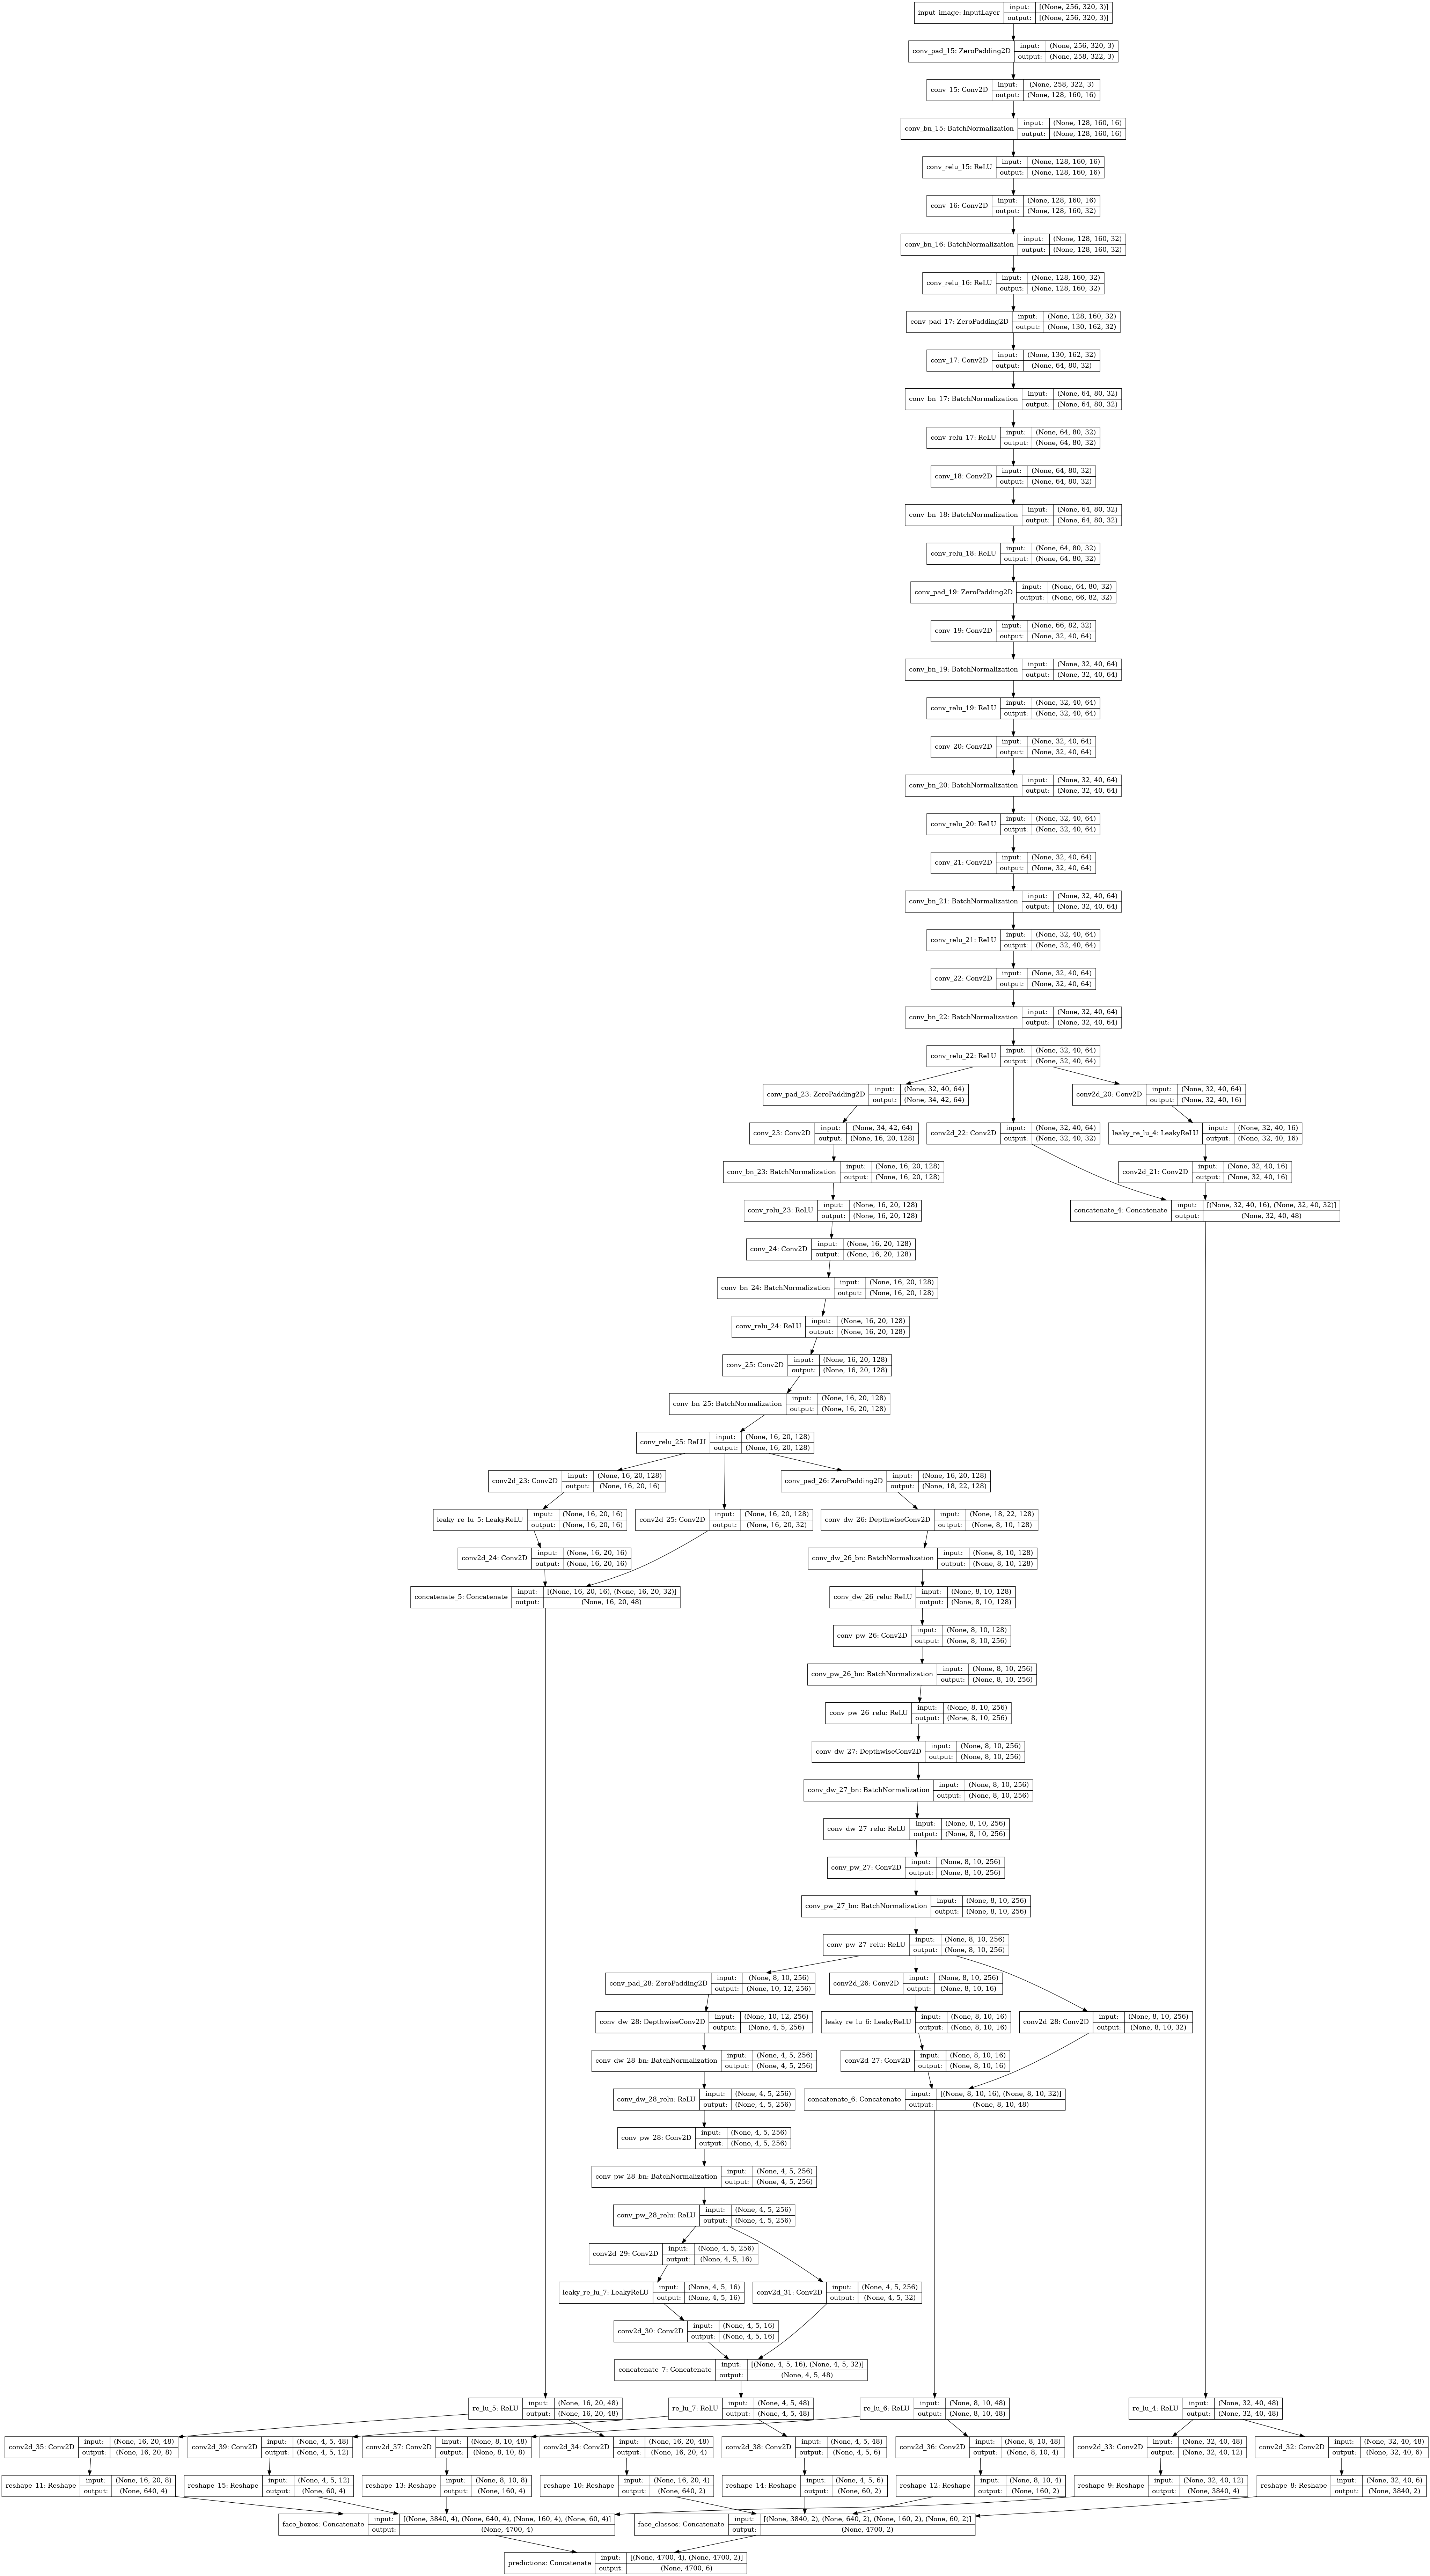

In [40]:
model = SsdModel()
model.summary()
tf.keras.utils.plot_model(
    model, 
    to_file=os.path.join(os.getcwd(), 'model.png'),
    show_shapes=True, 
    show_layer_names=True
)

In [41]:
steps_per_epoch = DATASET_LEN // BATCH_SIZE
learning_rate = MultiStepWarmUpLR(
    initial_learning_rate=1e-2,
    lr_steps=[e*steps_per_epoch for e in [50, 70]],
    lr_rate=0.1,
    warmup_steps=5*steps_per_epoch,
    min_lr=1e-4
)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

multi_loss = MultiBoxLoss(len(IMAGE_LABELS), neg_pos_ratio=3)

print('슝=3')

슝=3


이제 학습이 진행될 함수를 작성할 차례입니다. tf.GradientTape()을 사용하는 방식에 익숙해 지셨나요? 아직 어렵다면 아래 링크를 참고하세요!

- [GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape)
- [Writing a training loop from scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)

한 스텝이 학습되는 함수를 아래처럼 작성합니다.

In [42]:
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        losses = {}
        losses['reg'] = tf.reduce_sum(model.losses)  #unused. Init for redefine network
        losses['loc'], losses['class'] = multi_loss(labels, predictions)
        total_loss = tf.add_n([l for l in losses.values()])

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, losses

print('슝=3')

슝=3


In [46]:
import pandas as pd

log = pd.DataFrame(columns = ['EPOCHS','Loss','loc loss','class loss'])
log

,EPOCHS,Loss,loc loss,class loss


In [47]:
EPOCHS = 200
for epoch in range(0, EPOCHS):
    for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
        load_t0 = time.time()
        total_loss, losses = train_step(inputs, labels)
        load_t1 = time.time()
        batch_time = load_t1 - load_t0
        print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ",end = '',flush=True)

    log.loc[epoch, 'EPOCHS'] = EPOCHS
    log.loc[epoch, 'Loss']= total_loss
    log.loc[epoch, 'loc loss'] = losses['loc']
    log.loc[epoch, 'class loss'] = losses['class']
    
    if (epoch+1) % 50 == 0:
        model.save_weights(f'./model_epochs_{epoch+1}.h5')
log.to_csv('train_log.csv',index =False)

Epoch: 200/200 | Batch 402/402 | Batch time 0.052 || Loss: 3.165696 | loc loss:2.241736 | class loss:0.923959  

In [ ]:
EPOCHS = 100
for epoch in range(200, 200+EPOCHS):
    for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
        load_t0 = time.time()
        total_loss, losses = train_step(inputs, labels)
        load_t1 = time.time()
        batch_time = load_t1 - load_t0
        print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ",end = '',flush=True)

    log.loc[epoch, 'EPOCHS'] = epoch
    log.loc[epoch, 'Loss']= total_loss
    log.loc[epoch, 'loc loss'] = losses['loc']
    log.loc[epoch, 'class loss'] = losses['class']
    
    if (epoch+1) % 50 == 0:
        model.save_weights(f'./model_epochs_{epoch+1}.h5')

Epoch: 279/100 | Batch 53/402 | Batch time 0.052 || Loss: 4.036314 | loc loss:2.918591 | class loss:1.117723   

In [5]:
log['EPOCHS'] = range(200)

In [7]:
log

,EPOCHS,Loss,loc loss,class loss
0,0,"tf.Tensor(7.3632455, shape=(), dtype=float32)","tf.Tensor(5.5604634, shape=(), dtype=float32)","tf.Tensor(1.8027822, shape=(), dtype=float32)"
1,1,"tf.Tensor(6.107567, shape=(), dtype=float32)","tf.Tensor(4.2435417, shape=(), dtype=float32)","tf.Tensor(1.8640251, shape=(), dtype=float32)"
2,2,"tf.Tensor(6.6211557, shape=(), dtype=float32)","tf.Tensor(4.9732523, shape=(), dtype=float32)","tf.Tensor(1.6479037, shape=(), dtype=float32)"
3,3,"tf.Tensor(6.9368973, shape=(), dtype=float32)","tf.Tensor(5.093856, shape=(), dtype=float32)","tf.Tensor(1.8430415, shape=(), dtype=float32)"
4,4,"tf.Tensor(7.3903503, shape=(), dtype=float32)","tf.Tensor(5.7737327, shape=(), dtype=float32)","tf.Tensor(1.6166178, shape=(), dtype=float32)"
...,...,...,...,...
195,195,"tf.Tensor(5.859154, shape=(), dtype=float32)","tf.Tensor(4.9050083, shape=(), dtype=float32)","tf.Tensor(0.9541457, shape=(), dtype=float32)"
196,196,"tf.Tensor(3.720814, shape=(), dtype=float32)","tf.Tensor(2.9140697, shape=(), dtype=float32)","tf.Tensor(0.8067444, shape=(), dtype=float32)"
197,197,"tf.Tensor(5.0419683, shape=(), dtype=float32)","tf.Tensor(4.0508986, shape=(), dtype=float32)","tf.Tensor(0.99107003, shape=(), dtype=float32)"
198,198,"tf.Tensor(4.4763136, shape=(), dtype=float32)","tf.Tensor(3.675617, shape=(), dtype=float32)","tf.Tensor(0.8006966, shape=(), dtype=float32)"


In [29]:
[float(x.split('(')[1].split(',')[0]) for x in log['Loss'].tolist()]
# csv로  저장했더니 문자열로 저장되버리는 문제가 발생함

[7.3632455,
 6.107567,
 6.6211557,
 6.9368973,
 7.3903503,
 5.143525,
 5.172701,
 7.371089,
 5.330692,
 5.3916607,
 8.043712,
 6.505695,
 5.0198536,
 4.9095445,
 7.155316,
 5.186952,
 7.0854096,
 5.2722344,
 3.6770084,
 4.281192,
 4.7060957,
 5.433864,
 4.1899776,
 5.0808496,
 3.3573956,
 4.8448153,
 4.911791,
 5.9697456,
 5.2385464,
 3.6046462,
 4.9002237,
 4.284612,
 4.6531525,
 4.794817,
 4.466942,
 3.3938837,
 4.8968687,
 5.5240617,
 3.1539054,
 4.928505,
 4.8269057,
 4.5214524,
 5.823189,
 4.075435,
 6.739049,
 5.752662,
 3.4154723,
 4.15232,
 6.014431,
 5.0947294,
 4.0536404,
 5.066837,
 6.5679727,
 7.335681,
 7.0306377,
 2.945093,
 3.5572772,
 5.2236395,
 5.6010556,
 4.727631,
 4.1964874,
 3.4306679,
 4.2023444,
 3.7016943,
 3.7860906,
 3.8344543,
 4.3640823,
 4.4968767,
 2.6013927,
 4.16501,
 3.3934655,
 4.142628,
 3.814268,
 4.2021937,
 5.922991,
 6.7591915,
 6.5736456,
 4.3201947,
 3.200442,
 4.182541,
 4.1718287,
 5.7073364,
 4.379813,
 4.2716546,
 5.4813576,
 4.7671824,
 4.

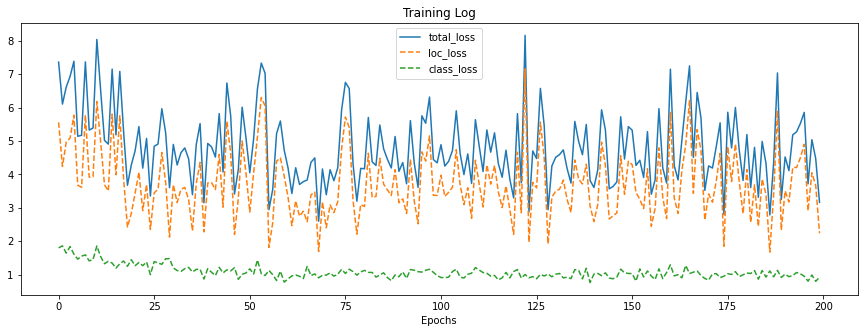

In [30]:
plt.figure(figsize = (15,5))
plt.title('Training Log')
plt.plot(range(200), [float(x.split('(')[1].split(',')[0]) for x in log['Loss'].tolist()],label = 'total_loss')
plt.plot(range(200), [float(x.split('(')[1].split(',')[0]) for x in log['loc loss'].tolist()],'--',label = 'loc_loss')
plt.plot(range(200), [float(x.split('(')[1].split(',')[0]) for x in log['class loss'].tolist()],'--',label = 'class_loss')
plt.legend()
plt.xlabel('Epochs')
# plt.ylabel('Losses')
plt.show()

### NMS 구현하기
---
Grid cell을 사용하는 Object detection의 inference 단계에서 하나의 object가 여러 개의 default box에 걸쳐져 있을 때 IoU가 가장 높은 default box를 선택하는 NMS(non-max suppression)이 필요합니다. 아래 코드를 확인해 주세요.

> NMS(non-max suppression)는 Object Detector가 예측한 수많은 bounding box 중에서 중복된 경계 상자를 제거하여 정확한 bounding box를 선택하도록 하는 알고리즘입니다.

In [67]:
def compute_nms(boxes, scores, nms_threshold=0.98, limit=200):
    if boxes.shape[0] == 0:
        return tf.constant([], dtype=tf.int32)
    selected = [0]
    idx = tf.argsort(scores, direction='DESCENDING')
    idx = idx[:limit]
    boxes = tf.gather(boxes, idx)

    iou = _jaccard(boxes, boxes)

    while True:
        row = iou[selected[-1]]
        next_indices = row <= nms_threshold

        iou = tf.where(
            tf.expand_dims(tf.math.logical_not(next_indices), 0),
            tf.ones_like(iou, dtype=tf.float32),
            iou
        )

        if not tf.math.reduce_any(next_indices):
            break

        selected.append(tf.argsort(
            tf.dtypes.cast(next_indices, tf.int32), direction='DESCENDING')[0].numpy())

    return tf.gather(idx, selected)

print('슝=3')

슝=3


In [32]:
def decode_bbox_tf(predicts, boxes, variances=[0.1, 0.2]):
    centers = boxes[:, :2] + predicts[:, :2] * variances[0] * boxes[:, 2:]
    sides = boxes[:, 2:] * tf.math.exp(predicts[:, 2:] * variances[1])
    return tf.concat([centers - sides / 2, centers + sides / 2], axis=1)

print('슝=3')

슝=3


In [33]:
def parse_predict(predictions, boxes):
    label_classes = IMAGE_LABELS

    bbox_predictions, confidences = tf.split(predictions[0], [4, -1], axis=-1)
    boxes = decode_bbox_tf(bbox_predictions, boxes)

    scores = tf.math.softmax(confidences, axis=-1)

    out_boxes = []
    out_labels = []
    out_scores = []

    for c in range(1, len(label_classes)):
        cls_scores = scores[:, c]

        score_idx = cls_scores > 0.5

        cls_boxes = boxes[score_idx]
        cls_scores = cls_scores[score_idx]

        nms_idx = compute_nms(cls_boxes, cls_scores)

        cls_boxes = tf.gather(cls_boxes, nms_idx)
        cls_scores = tf.gather(cls_scores, nms_idx)

        cls_labels = [c] * cls_boxes.shape[0]

        out_boxes.append(cls_boxes)
        out_labels.extend(cls_labels)
        out_scores.append(cls_scores)

    out_boxes = tf.concat(out_boxes, axis=0)
    out_scores = tf.concat(out_scores, axis=0)

    boxes = tf.clip_by_value(out_boxes, 0.0, 1.0).numpy()
    classes = np.array(out_labels)
    scores = out_scores.numpy()

    return boxes, classes, scores

print('슝=3')

슝=3


#### 사진에서 여러개의 얼굴을 찾아보자.
---
이제 다 왔습니다. SSD 모델을 통해 우리는 Multi-face detection 기능을 확보했습니다.
얼마나 잘 해내는지 확인해 보도록 합시다.

우선 입력할 이미지의 비율이 달라도 모델이 잘 작동할 수 있도록 이미지 패딩을 추가/제거해주는 함수를 만들어 줍니다.

In [34]:
def pad_input_image(img, max_steps):
    img_h, img_w, _ = img.shape

    img_pad_h = 0
    if img_h % max_steps > 0:
        img_pad_h = max_steps - img_h % max_steps

    img_pad_w = 0
    if img_w % max_steps > 0:
        img_pad_w = max_steps - img_w % max_steps

    padd_val = np.mean(img, axis=(0, 1)).astype(np.uint8)
    img = cv2.copyMakeBorder(img, 0, img_pad_h, 0, img_pad_w,
                             cv2.BORDER_CONSTANT, value=padd_val.tolist())
    pad_params = (img_h, img_w, img_pad_h, img_pad_w)

    return img, pad_params

print('슝=3')

슝=3


In [35]:
def recover_pad(boxes, pad_params):
    img_h, img_w, img_pad_h, img_pad_w = pad_params
    box = np.reshape(boxes[0], [-1, 2, 2]) * [(img_pad_w + img_w) / img_w, (img_pad_h + img_h) / img_h]
    boxes[0] = np.reshape(box, [-1, 4])
    return boxes

print('슝=3')

슝=3


In [36]:
def draw_box_on_face(img, boxes, classes, scores, box_index, class_list):
    img_height = img.shape[0]
    img_width = img.shape[1]

    x_min = int(boxes[box_index][0] * img_width)
    y_min = int(boxes[box_index][1] * img_height)
    x_max = int(boxes[box_index][2] * img_width)
    y_max = int(boxes[box_index][3] * img_height)

    if classes[box_index] == 1:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
    
    if len(scores) > box_index :
        score = "{:.4f}".format(scores[box_index])
        class_name = class_list[classes[box_index]]
        label = '{} {}'.format(class_name, score)
        position = (x_min, y_min - 4) 
        cv2.putText(img, label, position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))

print('슝=3')

슝=3


아래 코드를 실행하여 클라우드에 저장된 테스트용 이미지의 결과를 확인해보세요.

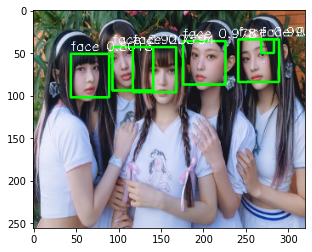

In [68]:
# filepath = os.path.join(PROJECT_PATH, 'checkpoints', 'weights_epoch_008.h5')
filepath = 'model_epochs_300.h5'
model.load_weights(filepath)

TEST_IMAGE_PATH = os.path.join(PROJECT_PATH, 'newjeans.jpg')

img_raw = cv2.imread(TEST_IMAGE_PATH)
img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
img = np.float32(img_raw.copy())

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
img = img / 255.0

boxes = default_box()
boxes = tf.cast(boxes, tf.float32)

predictions = model.predict(img[np.newaxis, ...])

pred_boxes, labels, scores = parse_predict(predictions, boxes)
pred_boxes = recover_pad(pred_boxes, pad_params)

for box_index in range(len(pred_boxes)):
    draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)

plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
plt.show()

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/GC-11-P-05.png)
위의 예시를 보면 대체로 얼굴 전체를 잡는 경우가 있으므로 중앙 약간 하부를 코로 가정하여 위치를 지정

In [69]:
my_image_path = os.path.join(PROJECT_PATH, 'newjeans.jpg')
sticker_path = os.path.join(PROJECT_PATH, 'cat-whiskers.png')

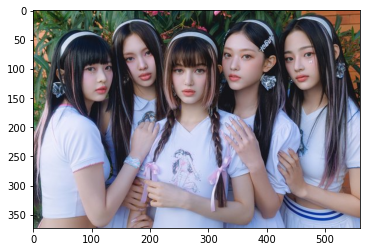

In [70]:
img_bgr = cv2.imread(my_image_path)                # 사진 불러오기
img_src = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR 형식을 RGB 형식으로 변환
plt.imshow(img_src)
plt.show()

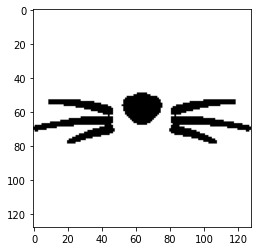

In [98]:
# 스티커 이미지 원본 데이터
img_sticker_src = cv2.imread(sticker_path)
img_sticker = img_sticker_src.copy()
plt.imshow(img_sticker_src)
plt.show()

In [103]:
def draw_sticker_on_face(img, boxes, box_index, img_sticker):
    img_height = img.shape[0]
    img_width = img.shape[1]

    x_min = int(boxes[box_index][0] * img_width)
    y_min = int(boxes[box_index][1] * img_height)
    x_max = int(boxes[box_index][2] * img_width)
    y_max = int(boxes[box_index][3] * img_height)
    
    w = x_max - x_min
    h = y_max - y_min 
    
    # 스티커 이미지를 사용자 얼굴에 맞춰 크기 조정
    img_sticker = cv2.resize(img_sticker, (w, h))     
    
    # 스티커 배치를 위해 스티커의 죄상단이 위치할 좌표 계산
    refined_x = int(x_min)
    refined_y = int(y_min + h * 0.15) # 코는 약간 하단부로

    if refined_x < 0: 
        img_sticker = img_sticker[:, -refined_x:]
        refined_x = 0
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:, :]
        refined_y = 0

    
    sticker_area = img[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    
    img[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
                            np.where(img_sticker == 0,img_sticker, sticker_area).astype(np.uint8)
    
    
#     alpha = 0.5  # 살짝 투명하게 넣기위해
#     img[int(refined_y):int(refined_y) +img_sticker.shape[0], int(refined_x):int(refined_x)+img_sticker.shape[1]] = \
#         cv2.addWeighted(sticker_area, alpha, np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8), 1-alpha, 0)  
    # 컬러 값 0(검정색)
    
    return img

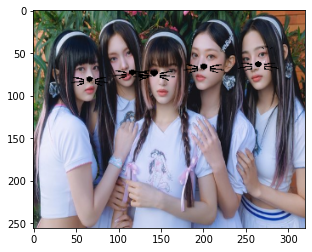

In [74]:
def draw_sticker(TEST_IMAGE_PATH, img_sticker):
    
    img_raw = cv2.imread(TEST_IMAGE_PATH)
    img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
    img = np.float32(img_raw.copy())

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
    img = img / 255.0

    boxes = default_box()
    boxes = tf.cast(boxes, tf.float32)

    predictions = model.predict(img[np.newaxis, ...])

    pred_boxes, labels, scores = parse_predict(predictions, boxes)
    pred_boxes = recover_pad(pred_boxes, pad_params)
    
    for box_index in range(len(pred_boxes)):
        draw_sticker_on_face(img_raw, pred_boxes, box_index, img_sticker)

    plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
    plt.show()
    
draw_sticker(TEST_IMAGE_PATH, img_sticker)

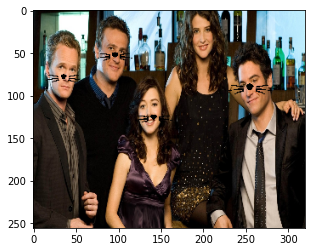

In [77]:
draw_sticker('./how_i_met_your_mother.jpg', img_sticker)

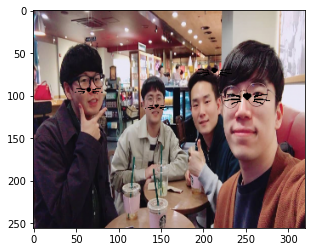

In [78]:
draw_sticker('./image.png', img_sticker)

다른 스티커

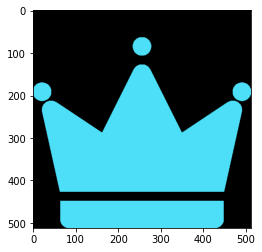

In [79]:
# 스티커 이미지 원본 데이터
img_sticker_src = cv2.imread('king.png')
img_sticker = img_sticker_src.copy()
plt.imshow(img_sticker_src)
plt.show()

In [85]:
def draw_sticker_on_face(img, boxes, box_index, img_sticker):
    img_height = img.shape[0]
    img_width = img.shape[1]

    x_min = int(boxes[box_index][0] * img_width)
    y_min = int(boxes[box_index][1] * img_height)
    x_max = int(boxes[box_index][2] * img_width)
    y_max = int(boxes[box_index][3] * img_height)
    
    w = x_max - x_min
    h = y_max - y_min 
    
    # 스티커 이미지를 사용자 얼굴에 맞춰 크기 조정
    img_sticker = cv2.resize(img_sticker, (w, h))     
    
    # 스티커 배치를 위해 스티커의 죄상단이 위치할 좌표 계산
    refined_x = int(x_min)
#     refined_y = int(y_min + h * 0.15) # 코는약간 하단부로
    refined_y = int(y_min - h * 1.) # 머리는 많이 위로

    if refined_x < 0: 
        img_sticker = img_sticker[:, -refined_x:]
        refined_x = 0
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:, :]
        refined_y = 0

    
    sticker_area = img[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    
    img[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
                            np.where(img_sticker == 0, sticker_area, img_sticker).astype(np.uint8)
    
    
#     alpha = 0.5  # 살짝 투명하게 넣기위해
#     img[int(refined_y):int(refined_y) +img_sticker.shape[0], int(refined_x):int(refined_x)+img_sticker.shape[1]] = \
#         cv2.addWeighted(sticker_area, alpha, np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8), 1-alpha, 0)  
    # 컬러 값 0(검정색)
    
    return img

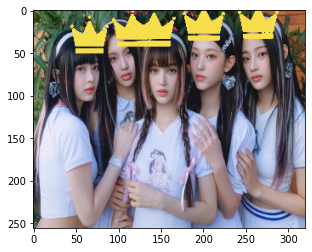

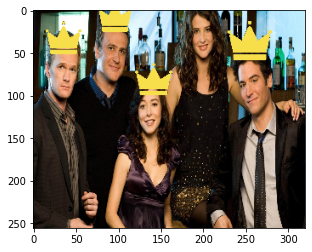

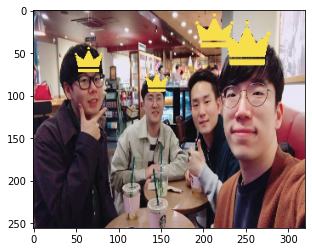

In [86]:
draw_sticker(TEST_IMAGE_PATH, img_sticker)
draw_sticker('./how_i_met_your_mother.jpg', img_sticker)
draw_sticker('./image.png', img_sticker)

(additional) dlib 이용

In [88]:
from numpy.linalg import norm   # 이미지 회전 각 계산
import dlib                     # 얼굴 인식, 얼굴 랜드마크 알고리즘

In [89]:
main_dir = os.getenv('HOME') + '/aiffel/face_detector/' # project location
model_dir = os.getenv('HOME') + '/aiffel/camera_sticker/models/' #sticker ex location
# 스티커를 붙일 사진 파일
my_image_path = os.path.join(main_dir, 'newjeans.jpg')

img_bgr = cv2.imread(my_image_path)                # 사진 불러오기
img_src = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR 형식을 RGB 형식으로 변환

In [90]:
# 얼굴 인식 알고리즘
detector_hog = dlib.get_frontal_face_detector()
# 얼굴 랜드마크 알고리즘
model_path = os.path.join(model_dir, 'shape_predictor_68_face_landmarks.dat') # 모델 파라미터 파일
landmark_predictor = dlib.shape_predictor(model_path)

# 얼굴 bounding box 찾기
def detect_face(detector, img, num_pyramid_layer=1):
    dlib_rects = detector(img, num_pyramid_layer)
    return dlib_rects


# 얼굴 bounding box 그리기
def draw_face_bbox(img, rects, color=(0, 255, 0), line_width=2):
    for rect in rects:
        # bounding box 좌표값 가져오기
        l = rect.left()
        t = rect.top()
        r = rect.right()
        b = rect.bottom()
        
        # bounding box를 img에 그리기
        cv2.rectangle(img, (l,t), (r,b), color, line_width, lineType=cv2.LINE_AA)
    
    return img

In [91]:
# 얼굴 bounding box 찾기
def detect_face(detector, img, num_pyramid_layer=1):
    dlib_rects = detector(img, num_pyramid_layer)
    return dlib_rects


# 얼굴 bounding box 그리기
def draw_face_bbox(img, rects, color=(0, 255, 0), line_width=2):
    for rect in rects:
        # bounding box 좌표값 가져오기
        l = rect.left()
        t = rect.top()
        r = rect.right()
        b = rect.bottom()
        
        # bounding box를 img에 그리기
        cv2.rectangle(img, (l,t), (r,b), color, line_width, lineType=cv2.LINE_AA)
    
    return img

In [92]:
img_res = img_src.copy() # 원본 이미지를 유지하기 위해 복사

# 이미지에서 얼굴 bound box 구하기
dlib_rects = detect_face(detector_hog, img_res)

In [93]:
# 얼굴별 랜드마크 찾기
def get_face_landmarks(predictor, img, rects):
    list_landmarks = [] # 각 얼굴의 랜드마크 리스트
    
    for rect in rects:
        # 얼굴 bounding box 내 얼굴 랜드마크 찾기
        points = predictor(img, rect)
        
        # 각 랜드마크 위치를 튜플로 변환
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        
        # 리스트에 저장
        list_landmarks.append(list_points)
    
    return list_landmarks


# 얼굴별 랜드마크 그리기
def draw_face_landmarks(img, list_landmarks, point_size=2, color=(0, 255, 255)):
    # 각 얼굴마다 반복
    for landmark in list_landmarks:
        # 각 랜드마크마다 반복
        for i, point in enumerate(landmark):
            # 특정 랜드마크에 다른 색 지정
            if i == 30:
                color_ = (255, 0, 0)
            elif i == 33:
                color_ = (0, 0, 255)
            else:
                color_ = color
                
            # 해당 랜드마크에 점 그리기
            cv2.circle(img, point, point_size, color_, -1)
    
    return img

In [94]:
# bounding box내에서 얼굴 랜드마크 구하기
list_landmarks = get_face_landmarks(landmark_predictor, img_res, dlib_rects)

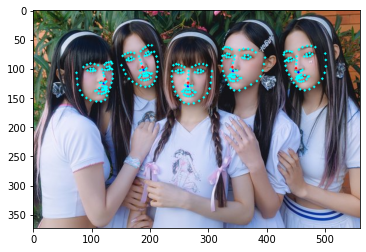

In [95]:
# 얼굴 랜드마크 확인하기
img_res = draw_face_landmarks(img_res, list_landmarks)

plt.imshow(img_res)
plt.show()

In [96]:
def attach_sticker(img, img_sticker_src, rects, list_landmarks):
    if len(rects) != len(list_landmarks):
        print("인식한 얼굴 수와 랜드마크가 지정된 얼굴 수가 다름")
    
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        # 얼굴이 회전한 각도를 계산
        nose_horizontal = (landmark[35][0] - landmark[31][0],           # 코의 수평선 벡터 
                           landmark[35][1] - landmark[31][1])
        cos_ = np.dot((1,0), nose_horizontal) / (norm(nose_horizontal)) # x축과 수평선 사이의 코사인 계산
        theta = np.arccos(cos_) / np.pi * 180                           # 두 선 사이의 각도 계산
        
        # 코의 수평선 벡터 방향에 맞춰 회전 방향 변경
        if nose_horizontal[1] > 0:
            theta = -theta
        
        # 스티커의 중심점 위치와 크기 지정
        x = landmark[30][0]
        y = landmark[30][1] + dlib_rect.height() // 2
        w = h = dlib_rect.width()

        # 원본 스터커 이미지를 복사
        img_sticker = img_sticker_src.copy()
        
        # 스티커 이미지를 사용자 얼굴에 맞춰 크기 조정
        img_sticker = cv2.resize(img_sticker, (w, h))

        # 스티커 이미지 회전
        img_sticker = 255 - img_sticker                                   # 스티커 이미지 색반전
        M_rotate = cv2.getRotationMatrix2D((w // 2, h // 2), theta, 1.0 ) # 회전 행렬 구하기
        img_sticker = cv2.warpAffine(img_sticker, M_rotate, (w, h))       # 스티커에 회전 행렬 적용
        img_sticker = 255 - img_sticker                                   # 스티커 이미지 다시 색반전
        
        # 스티커 배치를 위해 스티커의 죄상단이 위치할 좌표 계산
        refined_x = x - w // 2
        refined_y = y - h

        # 좌상단이 인물 이미지 밖인 경우 스티커 이미지를 자르기
        if refined_x < 0:
            img_sticker = img_sticker[:, -refined_x:] # 밖에 나온 영역만큼 자르기
            refined_x = 0                             # 좌표를 최솟값에 맞추기

        if refined_y < 0:
            img_sticker = img_sticker[-refined_y:, :]
            refined_y = 0

        # 스티커가 붙을 영역의 좌표 범위 구하기
        x_min = refined_x
        x_max = refined_x + img_sticker.shape[1]
        y_min = refined_y
        y_max = refined_y + img_sticker.shape[0]
            
        # 스티커가 붙을 영역을 가져오기
        sticker_area = img[y_min:y_max, x_min:x_max]

        # 스티커 이미지의 배경을 자르고 인물 이미지에 오버레이
        # 스티커의 흰 배경은 인물 이미지를 넣기
        img[y_min:y_max, x_min:x_max] = \
            np.where(img_sticker == 255, sticker_area, img_sticker).astype(np.uint8)
    
    return img

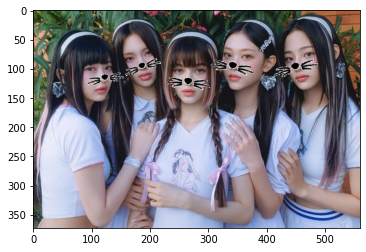

In [99]:
img_res = img_src.copy() # 원본 이미지 복사

img_res = attach_sticker(img_res, img_sticker_src, dlib_rects, list_landmarks)

plt.imshow(img_res)
plt.show()

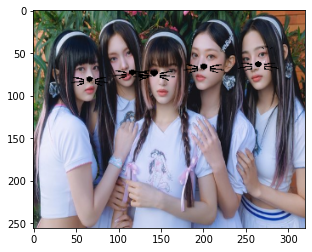

In [104]:
# dlib 과 비교
draw_sticker(TEST_IMAGE_PATH, img_sticker)

### 회고

- 100 이상이어야 얼굴 부위를 인식하는 경향을 보임
- 학습 자체는 1 epoch에 3분정도씩 걸렸기 때문에 그 동안 다른 실험을 하긴했으나 퀘스트 시간에서는 20회 겨우 하고 추가로 실험을 진행함 

- 다양한 파라미터 조정을 하지 않고 epoch로만 조정했기 때문에 별로 성능의 큰 향상을 보지는 못함
- box안에 작게 box가 생기는 모습을 보았는데 nms 0.99 조정으로도 제거 되지 않았음...

- 300 회 이상 돌린 모델의 weight가 5mb가 넘지 않아서 굉장히 가벼운 모델이라는 것이 실감났음 
- 실시간 인식이 가능하지 않을까 싶기도 하고 on-camera는 해보지 않아서 찾아보면 재밌을 실험일 것 같다.

- 스티커를 붙히는 부위별로 위치를 바꿔야해서 기존 카메라 어플에서 이에 따른 조건은 어떻게 저장하는 지 궁금했다.

- 스티커의 경우 얼굴 특정 부위에 붙혀야하는 경우 (고양이 수염) 얼굴의 landmark를 이용하는 경우가 더 정확하게 붙는다. 그렇지만 빠르게 인식되어야하고 용량이 가벼워야하기 때문에 일반적인 위치에 붙혀도 되는 경우에는 ssd를 쓰는 것이 좋을 것 같다. 